In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [38]:
# set theinitial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 64

In [39]:
DIRECTORY = r"D:\NUS\Project PRS\Face\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [40]:
print("[INFO] loading images...")

[INFO] loading images...


In [41]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(128, 128))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

C:\Users\Geet\Anaconda3\lib\site-packages\PIL\Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [42]:
# one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [43]:
# data augmentation
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.20,
    horizontal_flip=True,
    fill_mode="nearest")

In [44]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(128, 128, 3)))

In [45]:
# construct the head of the model that will be placed on top of the base
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [46]:
#the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over layers in the base model and freeze them
for layer in baseModel.layers:
    layer.trainable = False

In [47]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [48]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] training head...
Epoch 1/20
47/47 [==============================] - 23s 486ms/step - loss: 0.8983 - accuracy: 0.6779 - val_loss: 0.1689 - val_accuracy: 0.9387
Epoch 2/20
47/47 [==============================] - 23s 494ms/step - loss: 0.3348 - accuracy: 0.8658 - val_loss: 0.1064 - val_accuracy: 0.9648
Epoch 3/20
47/47 [==============================] - 24s 511ms/step - loss: 0.2505 - accuracy: 0.9017 - val_loss: 0.0858 - val_accuracy: 0.9700
Epoch 4/20
47/47 [==============================] - 25s 526ms/step - loss: 0.1852 - accuracy: 0.9287 - val_loss: 0.0732 - val_accuracy: 0.9765
Epoch 5/20
47/47 [==============================] - 25s 525ms/step - loss: 0.1870 - accuracy: 0.9237 - val_loss: 0.0658 - val_accuracy: 0.9791
Epoch 6/20
47/47 [==============================] - 25s 526ms/step - loss: 0.1415 - accuracy: 0.9450 - val_loss: 0.0598 - val_accuracy: 0.9831
Epoch 7/20
47/47 [==============================] - 25s 531ms/step - loss: 0.1332 - accuracy: 0.9494 - val_loss: 0.055

In [49]:
predIdxs = np.argmax(predIdxs, axis=1)

#classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.96      0.98       383
without_mask       0.96      0.99      0.98       384

 avg / total       0.98      0.98      0.98       767



In [50]:
print("[INFO] saving mask detector model...")
model.save("mask_detector_2.model", save_format="h5")

[INFO] saving mask detector model...


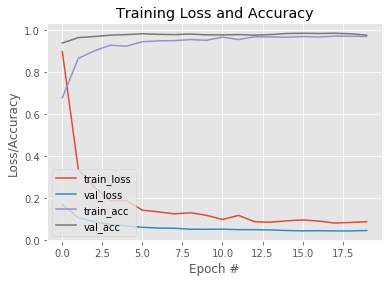

In [51]:
# training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")